In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../BBTRE_physics_analysis/") 

In [3]:
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
from xmitgcm import open_mdsdataset 
from xhistogram.xarray import histogram

from osse import *
from canyon_utils import *
from sloped_MITgcm import *

### Configuration parameters

In [4]:
# Constant parameters

Γ = 0.0008613659531090722
N = np.sqrt(g*α*Γ)
θ = 1.26E-3
f = -5.3e-5

h = 230
k0 = 5.2e-5
k1 = 1.8e-3

dx = 600.; dy = 600.
delta_t = 15.

### Load output

In [5]:
runname = "run"
data_dir = f"../../MITgcm/experiments/rotated_BBTRE_canyon-tracer/{runname}/"
budget_diags = ["budgetDiag", "tracer01Diag", "tracer02Diag", "tracer03Diag"]
ds = open_mdsdataset(data_dir,ignore_unknown_vars=True,prefix=budget_diags, delta_t=delta_t)

In [6]:
ds = ds.sel(time=ds['time'][1:])
ds = periodic_extend(ds, ['XC', 'XG'], dx, [-1,0])
xslice = [500, 500+800]
ds = ds.isel(XC=slice(*xslice), XG=slice(*xslice))
ds, grid = add_rotated_coords(ds, θ)
ds = ds.chunk({'XC': 400, 'XG': 400})
ds = ds.assign_coords({'dV': ds.drF * ds.rA * ds.hFacC})

ds = ds.assign_coords({'days': (ds['time'].astype('float64')*1.e-9/86400.) - 5000.*(delta_t/60.)})

In [7]:
t = [1., 420.]
ds = ds.isel(time=((ds['days']==t[0]) | (ds['days']==t[1])))

### Reconstructing the full temperature field

In [8]:
ds['THETA'] = ds['THETA'].where(ds['THETA'] != 0.)
ds['THETA_BG_C'] = Γ*ds['Zr']
ds['θ'] = ds['THETA'] + ds['THETA_BG_C']

In [9]:
def add_gradients(ds, v):
    ds[f'd{v}dx'] = grid.interp((
        grid.diff(ds[v], 'X', boundary='periodic').chunk({'XG': 400, 'YC':-1}) /
            ds['dxC']
        ), 'X', boundary='periodic'
    ).chunk({'XC': 400, 'YC':-1})

    ds[f'd{v}dy'] = grid.interp((
            grid.diff(ds[v], 'Y', boundary='periodic').chunk({'XC': 400, 'YG':-1}) /
            ds['dyC']
        ), 'Y', boundary='periodic'
    ).chunk({'XC': 400, 'YC':-1})

    ds[f'd{v}dz'] = grid.interp((
            grid.diff(ds[v], 'Z', boundary='extend').chunk({'XC': 400, 'Zl': -1}) /
            grid.diff(ds['Z'], 'Z', boundary='extend')
        ), 'Z', boundary='extend'
    )

In [10]:
add_gradients(ds, 'θ')
add_hab_coordinates(ds, grid, vert_coord='Z', gridface='C');

In [11]:
dx = ds.dxC[0,0].values
dy = ds.dyC[0,0].values
Lx = ds.dims['XC']
Ly = ds.dims['YC']

### Extensive variable transformations with xgcm (for budgets)

In [12]:
# define the target values in density
θ_target = np.linspace(0, 2.5, 50)

In [13]:
# target variable
ds["θ_outer"] = grid.interp(ds["θ"], 'Z', boundary='fill', to="outer").chunk({'Zp1': -1})

In [14]:
# mask negative tracer values (they don't affect results, but break the log-scale colorbar below)
ds["TRAC01"] = ds["TRAC01"].where(ds["TRAC01"] >= 0., 1.e-16)

In [60]:
def transform_to_θ(da, θ_outer, θ_target):
    return grid.transform(da,
                          'Z',
                          θ_target,
                          method='conservative',
                          target_data=θ_outer)

def first_moment(trans):
    assert ("cθdV" in trans.data_vars) & ("cdV" in trans.data_vars)
    trans["θbar"] = (trans["cθdV"].sum(dim=['θ_outer', 'YC', 'XC']) / trans["cdV"].sum(dim=['θ_outer', 'YC', 'XC'])).compute()
    Δt = ((trans['time'][1] - trans['time'][0])*1e-9).astype('float64')
    trans[f'd(θbar)dt_LHS-approx_Tr01'] = (
        trans["θbar"].isel(time=(trans['days']==t[1])).squeeze() -
        trans["θbar"].isel(time=(trans['days']==t[0])).squeeze()
    )/Δt
    
def second_moment(trans):
    assert ("c(θ^2)dV" in trans.data_vars) & ("cdV" in trans.data_vars)
    trans["(θ^2)bar"] = (trans["c(θ^2)dV"].sum(dim=['θ_outer', 'YC', 'XC']) / trans["cdV"].sum(dim=['θ_outer', 'YC', 'XC'])).compute()
    Δt = ((trans['time'][1] - trans['time'][0])*1e-9).astype('float64')
    trans[f'd((θ^2)bar)dt_LHS-approx_Tr01'] = (
        trans["(θ^2)bar"].isel(time=(trans['days']==t[1])).squeeze() -
        trans["(θ^2)bar"].isel(time=(trans['days']==t[0])).squeeze()
    )/Δt

In [62]:
# and transform
trans = xr.Dataset()
trans = trans.assign_coords({"dV": transform_to_θ(xr.broadcast(ds["dV"], ds["time"])[0], ds["θ_outer"], θ_target)})
trans["cdV"] = transform_to_θ(ds["TRAC01"]*ds["dV"], ds["θ_outer"], θ_target)
trans["cθdV"] = transform_to_θ(ds["TRAC01"]*ds["θ"]*ds["dV"], ds["θ_outer"], θ_target)
first_moment(trans)
trans["c(θ^2)dV"] = transform_to_θ(ds["TRAC01"]*((ds["θ"] - trans["θbar"])**2)*ds["dV"], ds["θ_outer"], θ_target)
second_moment(trans)

### Random sub-sampling

In [63]:
from scipy.interpolate import NearestNDInterpolator
import matplotlib.colors as colors

In [64]:
def generate_random_casts(coords, N):
    cast_nums = np.arange(0, N)
    casts = xr.DataArray(cast_nums, coords={"cast": cast_nums}, dims=("cast",))
    cast_i = xr.DataArray(np.random.randint(coords["XC"].size, size=N), coords=(casts,))
    cast_j = xr.DataArray(np.random.randint(coords["YC"].size, size=N), coords=(casts,))
    
    return xr.Dataset({"i": cast_i, "j": cast_j})

In [65]:
def sample_profile(cast, da):
    return da.isel(XC=cast.i, YC=cast.j)

In [66]:
def sample_profiles(casts, da):
    return xr.concat([sample_profile(casts.isel(cast=n), da) for n in range(casts.cast.size)], dim="cast")

In [67]:
X, Y = np.meshgrid(ds['XC'].values, ds['YC'].values)
def _neighbor_interp(x, y, z):
    valid_idx = z!=0
    if np.any(valid_idx):
        interp = NearestNDInterpolator(list(zip(x[valid_idx],y[valid_idx])), z[valid_idx])
        return interp(X,Y)
    else:
        return np.zeros_like(X)

def neighbor_interp(samples, coords):
    return xr.apply_ufunc(_neighbor_interp, samples.XC, samples.YC, samples,
                         input_core_dims=(["cast"], ["cast"], ["cast"]),
                         output_core_dims=[["YC", "XC"]],
                         vectorize=True,
                         dask="allowed").assign_coords({"XC": coords["XC"], "YC": coords["YC"]}).where(coords["dV"]!=0.)

def randomized_reconstruction(da, N, method="nearest neighbor", casts=None):
    if casts == None:
        casts = generate_random_casts(da.coords, N)
    samples = sample_profiles(casts, da)
    if method=="nearest neighbor":
        reconstruction = neighbor_interp(samples, da.coords)
    return reconstruction, samples

In [68]:
N = 100
da_reconstruction, samples = randomized_reconstruction(trans["cdV"], N);

In [69]:
def subsample_and_reconstruct_trans(trans, N):
    casts = generate_random_casts(trans.coords, N)
    
    reconstructed = xr.Dataset()
    for var in ["cdV", "cθdV", "c(θ^2)dV"]:
        reconstructed[var], _ = randomized_reconstruction(trans[var], N, casts=casts);
        reconstructed[var] = reconstructed[var].where(trans["time"]!=trans["time"][0], trans[var])
    first_moment(reconstructed)
    second_moment(reconstructed)
        
    return reconstructed

In [70]:
reconstructed = subsample_and_reconstruct_trans(trans, 10)

In [77]:
sensitivity = {}

Nsamples = 50
Ns = 2**np.arange(3, 12)

for N in Ns:
    print("N = ", N, end="; sample = ")
    sampling = {}
    for sample in range(Nsamples):
        print(sample, end=", ")
        sampling[sample] = subsample_and_reconstruct_trans(trans, N)
    print("\n")
    sensitivity[N] = sampling

N =  8; sample = 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 

N =  16; sample = 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 

N =  32; sample = 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 

N =  64; sample = 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 

N =  128; sample = 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 

In [88]:
f"../../data/reconstructions/trans_N-{N}_n-{n}"

'../../data/reconstructions/trans_N-8_n-0'

In [90]:
saving

<xarray.Dataset>
Dimensions:                        (XC: 800, YC: 100, time: 2, θ_outer: 49)
Coordinates:
    rA                             (YC, XC) float64 3.6e+05 3.6e+05 ... 3.6e+05
    days                           (time) float64 1.0 420.0
    iter                           (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time                           (time) timedelta64[ns] 1251 days 1670 days
  * θ_outer                        (θ_outer) float64 0.02551 0.07653 ... 2.474
  * XC                             (XC) float64 -1.797e+05 ... 2.997e+05
  * YC                             (YC) >f8 300.0 900.0 ... 5.91e+04 5.97e+04
    Depth                          (YC, XC) float64 dask.array<chunksize=(100, 400), meta=np.ndarray>
    dV                             (YC, XC, time, θ_outer) float64 dask.array<chunksize=(100, 400, 1, 49), meta=np.ndarray>
Data variables:
    cdV                            (time, θ_outer, YC, XC) float64 dask.array<chunksize=(1, 49, 100, 400), meta=np.ndarray>
    cθdV                           (time, θ_outer, YC, XC) float64 dask.array<chunksize=(1, 49, 100, 400), meta=np.ndarray>
    c(θ^2)dV                       (time, θ_outer, YC, XC) float64 dask.array<chunksize=(1, 49, 100, 400), meta=np.ndarray>
    Tbar                           (time) float64 1.084 1.181
    d(Tbar)dt_LHS-approx_Tr01      float64 2.675e-09
    (T^2)bar                       (time) float64 0.0004098 0.01636
    d((T^2)bar)dt_LHS-approx_Tr01  float64 4.406e-10

In [ ]:
for (n, (N, sampling)) in enumerate(sensitivity.items()):
    for (i, (sample, reconstructed)) in enumerate(sampling.items()):
        saving = reconstructed.copy()
        saving = saving.drop_vars(["cdV", "cθdV", "c(θ^2)dV"]).rename(
            {"d((θ^2)bar)dt_LHS-approx_Tr01": "d((T2)bar)dt_LHS-approx_Tr01",
             "θbar": "Tbar",
             "(θ^2)bar": "_(T2)bar",
             "d(θbar)dt_LHS-approx_Tr01": "d(Tbar)dt_LHS-approx_Tr01",
             "θ_outer": "T_outer"
        })
        saving.to_netcdf(f"../../data/reconstructions/trans_N-{N}_n-{i}")

In [ ]:
plt.figure(figsize=(6,7))
trans["cdV"].sum(["XC", "YC"]).isel(time=1).plot(y="θ_outer", color="grey", alpha=0.5, linestyle="-", lw=5, label=r"$\infty$")
for (N, reconstructed) in sensitivity.items():
    reconstructed[0]["cdV"].sum(["XC", "YC"]).isel(time=1).plot(y="θ_outer", label=str(N), alpha=0.4)
plt.legend(loc="upper right", labelspacing=0.2, ncol=2)
plt.title("")
plt.ylim([0.6, 1.6])

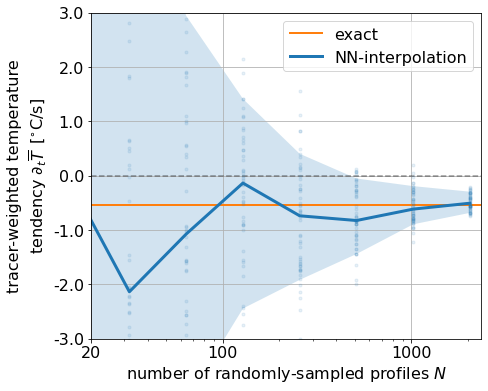

In [80]:
var = "d(θbar)dt_LHS-approx_Tr01"

plt.figure(figsize=(7,6))
plt.axhline(0., color="k", ls="--", alpha=0.4)
plt.axhline(trans[var], color="C1", ls="-", lw=2, label="exact")
medians = np.zeros(Ns.size)
q10 = np.zeros(Ns.size)
q90 = np.zeros(Ns.size)
for (n, (N, sampling)) in enumerate(sensitivity.items()):
    medians[n] = np.median([d[var] for d in sampling.values()])
    q10[n] = np.quantile([d[var] for d in sampling.values()], 0.1)
    q90[n] = np.quantile([d[var] for d in sampling.values()], 0.9)
    for (sample, reconstructed) in sampling.items():
        plt.semilogx([N], [reconstructed[var]], "C0.", alpha=0.1)
        
plt.fill_between(Ns, q10, q90, facecolor="C0", alpha=0.2)
plt.plot(Ns, medians, "C0-", lw=3, label="NN-interpolation")
plt.ylim([-3e-9, 3e-9]);
#plt.yscale('symlog', linthreshy=1e-11)
yt = plt.yticks()[0]
plt.yticks(yt, np.round(yt*1e9))
plt.ylabel(
    "tracer-weighted temperature\ntendency "+
    r"$\partial_{t} \overline{T}\,$ [$^{\circ}$C/s]"
)
plt.xlabel(r"number of randomly-sampled profiles $N$")
plt.grid(True)
plt.xlim(Ns[3]*0.8, Ns[-1]*1.15)
plt.xticks([20, 100, 1000], [20, 100, 1000]);
plt.legend(loc="upper right")

In [30]:
def plot_sample_reconstruction(da, samples, da_reconstruction):
    fig = plt.figure(figsize=(18,9))

    def formatting(ax):
        ax.set_ylabel("y [km]")
        ax.set_xlabel("x [km]")
        ax.set_xlim(ds.XC.min(), ds.XC.max())
        ax.set_ylim(ds.YC.min(), ds.YC.max())
        yt = np.arange(0, 80e3, 20e3)
        ax.set_yticks(yt)
        ax.set_yticklabels(np.int64(yt*1e-3))
        xt = np.arange(-100e3, 400e3, 100e3)
        ax.set_xticks(xt)
        ax.set_xticklabels(np.int64(xt*1e-3))

    ax = plt.subplot(3,1,1)
    SC = ax.scatter(samples.XC, samples.YC, c=samples,
                    edgecolors=(0.1, 0.1, 0.1, 0.3), s=50/np.log10(samples.XC.size+1),
                    norm=colors.LogNorm(vmin=da.max().values*1e-5, vmax=da.max().values))
    plt.colorbar(SC)
    formatting(ax)
    ax.set_title(fr"Simulated profiles ($N =${N})")
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_xlabel("")

    ax = plt.subplot(3,1,2)
    da_reconstruction.plot(ax=ax, norm=colors.LogNorm(vmin=da.max().values*1e-5, vmax=da.max().values), cmap="viridis")
    formatting(ax)
    ax.set_title("Nearest-neighbor interpolation of simulated profiles")
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_xlabel("")
    
    ax = plt.subplot(3,1,3)
    da.plot(ax=ax,norm=colors.LogNorm(vmin=da.max().values*1e-5, vmax=da.max().values), cmap="viridis")
    formatting(ax)
    ax.set_title("Simulated solution");

    plt.tight_layout()
    return fig

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


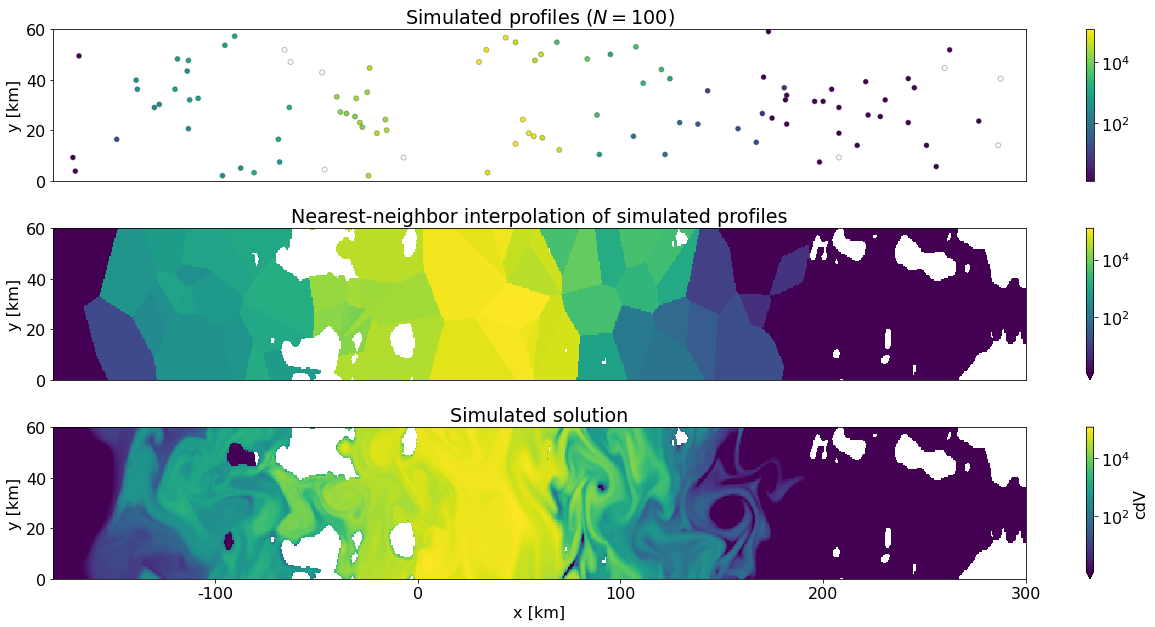

In [42]:
k = 20
fig = plot_sample_reconstruction(trans["cdV"].isel(time=1, θ_outer=k), samples.isel(time=1, θ_outer=k), da_reconstruction.isel(time=1, θ_outer=k));

### Tracer budgets

First, we evaluate the terms of the tracer and temperature budgets:
\begin{equation}
LHS = RHS = \text{Diffusion} + \text{Advection}
\end{equation}

In [ ]:
for tr, tr_name in enumerate(["_TH", "Tr01", "Tr02", "Tr03"]):
    tmp = tracer_flux_budget(ds, grid, tr_name, θ=θ, Γ=Γ).chunk({'Z': -1, 'YC': -1, 'XC': 400})
    if tr_name[0] != "_":
        tr_name = "_"+tr_name
    tmp[f'total_tendency{tr_name}'] = tmp[f'conv_total_flux{tr_name}'].fillna(0.)
    tmp[f'diff_tendency{tr_name}'] = tmp[f'conv_horiz_diff_flux{tr_name}'] + tmp[f'conv_vert_diff_flux{tr_name}']
    tmp[f'adv_tendency{tr_name}'] = tmp[f'conv_horiz_adv_flux{tr_name}'] + tmp[f'conv_vert_adv_flux{tr_name}']
    if tr_name == "_TH":
        tmp[f'adv_tendency{tr_name}'] = tmp[f'adv_tendency{tr_name}'] + tmp['conv_adv_flux_anom_TH']
        tmp[f'diff_tendency{tr_name}'] = tmp[f'diff_tendency{tr_name}'] + tmp['conv_vert_diff_flux_anom_TH']
        tmp[f'total_tendency_truth{tr_name}'] = ds.TOTTTEND * ds['dV'] * day2seconds
    else:
        tmp[f'total_tendency_truth{tr_name}'] = ds[f'Tp_g{tr_name[1:]}'] * ds['dV'] * day2seconds
    ds = xr.merge([ds, tmp])

## Various first moments

In [ ]:
for tr in [1, 2, 3]:
    print(f"Computing various 1st moments for Tracer {tr}")
    ds[f'M_Tr0{tr}'] = (ds[f'TRAC0{tr}']*ds['dV']).sum(dim=['Z', 'YC', 'XC']).compute()
    ds[f'Xbar_Tr0{tr}'] = ((ds['XC']*ds[f'TRAC0{tr}']*ds['dV']).sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute()
    ds[f'Zbar_Tr0{tr}'] = ((ds['Z']*ds[f'TRAC0{tr}']*ds['dV']).sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute()
    ds[f'Zrbar_Tr0{tr}'] = ((ds['Zr']*ds[f'TRAC0{tr}']*ds['dV']).sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute()
    ds[f'HABbar_Tr0{tr}'] = ((ds['Z_habC']*ds[f'TRAC0{tr}']*ds['dV']).sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute()
    ds[f'θbar_Tr0{tr}'] = ((ds['θ']*ds[f'TRAC0{tr}']*ds['dV']).sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute()

## First moment budget (tracer-weighted mean temperature)


The rate of change of the first temperature moment $\overline{\Theta} = \dfrac{\int \Theta c \,\text{d}V}{\int c \; \text{d}V}$ (average temperature of the tracer distribution) is given by

\begin{equation}
\int \partial_{t}  \left( \Theta c \right) \text{d}V + \int \left( c \nabla \cdot \mathbf{u} \Theta + \Theta \nabla \cdot \mathbf{u} c \right) \text{d}V = \int \left( c \nabla \cdot \mathbf{F_{\Theta}} + \Theta \nabla \cdot \mathbf{F_{c}} \right) \text{d}V,
\end{equation}
after dividing by the total tracer mass $M = \int c \; \text{d}V$.
 
In practice, we compute this budget by explicitly reconstructing each of the following terms from the tracer and temperature budgets. Each term is diagnosed from an instantaneous snapshot of the solution at machine precision and we can compare the LHS to the RHS to ensure our budget is closed (this is not guaranteed since the buoyancy and tracer equations are solved separetly).

**Note:** Is hyperdiffusion included in the diffusive diagnostics?

\begin{equation}
\int  \left( \Theta \partial_{t} c + c\partial_{t} \Theta \right) \text{d}V + \int \left( c \nabla \cdot \mathbf{u} \Theta + \Theta \nabla \cdot \mathbf{u} c \right) \text{d}V = \int \left( c \nabla \cdot \mathbf{F_{\Theta}} + \Theta \nabla \cdot \mathbf{F_{c}} \right) \text{d}V
\end{equation}

In practice, we decompose $\Theta = \overline{\Theta} + \Theta'$ where $\partial_{z} \overline{\Theta} = \Gamma$ is a constant lapse rate.

\begin{equation}
\int \left( \left( \overline{\Theta} + \Theta' \right) \partial_{t} c + c \partial_{t} \Theta' \right) \text{d}V +
\int \left( c \nabla \cdot \mathbf{u} \Theta' + cw \Gamma + (\overline{\Theta} + \Theta') \nabla \cdot \mathbf{u} c \right) \text{d}V =
\int \left( c \nabla \cdot \mathbf{F_{\Theta'}} - c \partial_{z} ( \kappa \Gamma) + (\overline{\Theta} + \Theta') \nabla \cdot \mathbf{F_{c}} \right) \text{d}V
\end{equation}

By applying no-flux and no-flow boundary conditions, this equation can be re-written in terms of just the temperature velocity $\omega = \nabla \cdot \left( \kappa \nabla \Theta \right)$,
\begin{equation}
\partial_{t} \overline{\Theta} = 2 \overline{\omega}
\end{equation}

In [ ]:
for tr in [1,2,3]:
    print(f"Computing 1st temperature moments for Tracer {tr}")
    ## Tracer mass
    ds[f'M_Tr0{tr}'] = (ds[f'TRAC0{tr}']*ds['dV']).sum(dim=['Z', 'YC', 'XC']).compute()
    
    ## LHS terms
    ds[f'c_dθdt_Tr0{tr}'] = ds[f'TRAC0{tr}'] * (ds['TOTTTEND']* day2seconds) * ds['dV']
    ds[f'θ_dcdt_Tr0{tr}'] = ds['θ'] * ds[f'Tp_gTr0{tr}'] * ds['dV']

    ## Full LHS
    ds[f'd(θbar)dt_Tr0{tr}'] = (
        (ds[f'c_dθdt_Tr0{tr}'].sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute() +
        (ds[f'θ_dcdt_Tr0{tr}'].sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute()
    )
    
    ## RHS terms
    # Advective terms
    ds[f'c_div_uθ_Tr0{tr}'] = ds[f'TRAC0{tr}']*ds['adv_tendency_TH']
    ds[f'θ_div_uc_Tr0{tr}'] = ds['θ']*ds[f'adv_tendency_Tr0{tr}']

    ds[f'd(θbar)dt_ADV_Tr0{tr}'] = (
        (ds[f'c_div_uθ_Tr0{tr}'].sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute() +
        (ds[f'θ_div_uc_Tr0{tr}'].sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute()
    )
    
    # Diffusive terms
    ds[f'c_div_Fθ_Tr0{tr}'] = ds[f'TRAC0{tr}']*ds['diff_tendency_TH']
    ds[f'θ_div_Fc_Tr0{tr}'] = ds['θ']*ds[f'diff_tendency_Tr0{tr}']

    ds[f'd(θbar)dt_DIFF_Tr0{tr}'] = (
        (ds[f'c_div_Fθ_Tr0{tr}'].sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute() + 
        (ds[f'θ_div_Fc_Tr0{tr}'].sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute()
    )
    
    # Full RHS
    ds[f'd(θbar)dt_RHS_Tr0{tr}'] = ds[f'd(θbar)dt_DIFF_Tr0{tr}'] + ds[f'd(θbar)dt_ADV_Tr0{tr}']
    
    # Buoyancy velocity term
    ds[f'ωbar_Tr0{tr}'] = ((ds['diff_tendency_TH'] * ds[f'TRAC0{tr}']).sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute()
    ds[f'2ω_Tr0{tr}'] = 2*ds[f'ωbar_Tr0{tr}']

In [ ]:
for tr in [1, 2, 3]:
    plt.figure(figsize=(8,7))
    (1e9*ds[f'd(θbar)dt_Tr0{tr}']).plot(x='days', linestyle="-", color="C1", lw=5, label=r"$\partial_{t}\, \overline{\theta}_{LHS}$")
    (1e9*ds[f'd(θbar)dt_RHS_Tr0{tr}']).plot(x='days', linestyle=":", color="k", lw=3, label=r"$\partial_{t}\, \overline{\theta}_{RHS}$")
    (1e9*ds[f'd(θbar)dt_DIFF_Tr0{tr}']).plot(x='days', color="C3", lw=5, label=r"$\partial_{t}\, \overline{\theta}_{DIFF}$")
    (1e9*ds[f'2ω_Tr0{tr}']).plot(x='days', linestyle="--", color="k",lw=2.5, label=r"$2\overline{\omega}$")
    (1e9*ds[f'd(θbar)dt_ADV_Tr0{tr}']).plot(x='days', color="C0", lw=2.5, linestyle="-", label=r"$\partial_{t}\, \overline{\theta}_{ADV}$")
    plt.legend()
    plt.ylabel(r"Tracer-averaged temperature tendency [10$^{-9}$ $\degree$C / s]")
    plt.grid(True)
    plt.title(f"BBTRE (Tracer {tr})")

## Second moment budget (tracer-weighted centered temperature variance)

The rate of change of the *second* temperature moment $\overline{\Theta^{2}} = \dfrac{\int \Theta^{2} c \,\text{d}V}{\int c \; \text{d}V}$ (average temperature variance of the tracer distribution) is given by

\begin{equation}
\int \partial_{t}  \left( \Theta c \right) \text{d}V + \int \left( c \nabla \cdot \mathbf{u} \Theta + \Theta \nabla \cdot \mathbf{u} c \right) \text{d}V = \int \left( c \nabla \cdot \mathbf{F_{\Theta}} + \Theta \nabla \cdot \mathbf{F_{c}} \right) \text{d}V,
\end{equation}
after dividing by the total tracer mass $M = \int c \; \text{d}V$.
 
In practice, we compute this budget by explicitly reconstructing each of the following terms from the tracer and temperature budgets. Each term is diagnosed from an instantaneous snapshot of the solution at machine precision and we can compare the LHS to the RHS to ensure our budget is closed (this is not guaranteed since the buoyancy and tracer equations are solved separetly).

**Note:** Is hyperdiffusion included in the diffusive diagnostics?

\begin{equation}
\int  \left( \Theta \partial_{t} c + c\partial_{t} \Theta \right) \text{d}V + \int \left( c \nabla \cdot \mathbf{u} \Theta + \Theta \nabla \cdot \mathbf{u} c \right) \text{d}V = \int \left( c \nabla \cdot \mathbf{F_{\Theta}} + \Theta \nabla \cdot \mathbf{F_{c}} \right) \text{d}V
\end{equation}

In practice, we decompose $\Theta = \overline{\Theta} + \Theta'$ where $\partial_{z} \overline{\Theta} = \Gamma$ is a constant lapse rate.

\begin{equation}
\int \left( \left( \overline{\Theta} + \Theta' \right) \partial_{t} c + c \partial_{t} \Theta' \right) \text{d}V +
\int \left( c \nabla \cdot \mathbf{u} \Theta' + cw \Gamma + (\overline{\Theta} + \Theta') \nabla \cdot \mathbf{u} c \right) \text{d}V =
\int \left( c \nabla \cdot \mathbf{F_{\Theta'}} - c \partial_{z} ( \kappa \Gamma) + (\overline{\Theta} + \Theta') \nabla \cdot \mathbf{F_{c}} \right) \text{d}V
\end{equation}

By applying no-flux and no-flow boundary conditions, this equation can be re-written in terms of just the temperature velocity $\omega = \nabla \cdot \left( \kappa \nabla \Theta \right)$,
\begin{equation}
\partial_{t} \overline{\Theta} = 2 \overline{\omega}
\end{equation}

In [ ]:
for tr in [1,2,3]:
    print(f"Computing 2nd moments for Tracer {tr}")
    
    ## LHS terms
    ds[f'2cθ_dθdt_Tr0{tr}'] = (2*ds[f'TRAC0{tr}']*ds['θ']) * (ds['TOTTTEND']* day2seconds) * ds['dV']
    ds[f'θ**2_dcdt_Tr0{tr}'] = ds['θ']**2 * (ds[f'Tp_gTr0{tr}'] * ds['dV'])
    ds[f'd(θbar**2)dt_Tr0{tr}'] = 2*ds[f'θbar_Tr0{tr}']*ds[f'd(θbar)dt_Tr0{tr}']
    
    ## Full LHS
    ds[f'd(θ**2bar)dt_Tr0{tr}'] = (
        (ds[f'2cθ_dθdt_Tr0{tr}'].sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute() +
        (ds[f'θ**2_dcdt_Tr0{tr}'].sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute()
    )
    
    # Centered Full LHS
    ds[f'd((θ-θbar)**2)bardt_Tr0{tr}'] = ds[f'd(θ**2bar)dt_Tr0{tr}'] - ds[f'd(θbar**2)dt_Tr0{tr}']
    
    # Gradients
    ds['Gradθ**2'] = ds['dθdx']**2 + ds['dθdy']**2 + ds[f'dθdz']**2
    ds[f'Gradθ**2bar_Tr0{tr}'] = ((ds['Gradθ**2']*ds[f'TRAC0{tr}']*ds['dV']).sum(['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute()
    
    ## In-situ diffusivity
    ds["κ"] = grid.interp(ds['KVDIFF'], 'Z', boundary='extend')
    ds[f"κbar_Tr0{tr}"] = ((ds["κ"]*ds[f'TRAC0{tr}']*ds['dV']).sum(['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute()
    
    ## Taylor diffusivity
    ds[f'κGradθ**2bar_Tr0{tr}'] = ((ds['κ']*ds['Gradθ**2']*ds[f'TRAC0{tr}']*ds['dV']).sum(['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute()
    ds[f"κTaylor_Tr{tr}"] = ds[f'κGradθ**2bar_Tr0{tr}']/ds[f'Gradθ**2bar_Tr0{tr}']
    
    #### Buoyancy-velocity correlation term
    ds[f"θbar_Tr0{tr}"] = ((ds['θ']*ds[f'TRAC0{tr}']*ds['dV']).sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute()
    ds[f"ωbarθbar_Tr0{tr}"] = ds[f'ωbar_Tr0{tr}']*ds[f'θbar_Tr0{tr}']
    ds[f"_(ωθ)bar_Tr0{tr}"] = (((ds['diff_tendency_TH']*ds['θ']) * ds[f'TRAC0{tr}']).sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute()
    ds[f"_(ωpθp)bar_Tr0{tr}"] = ds[f"_(ωθ)bar_Tr0{tr}"] - ds[f"ωbarθbar_Tr0{tr}"]
     
    ## Omega diffusivity
    ds[f"κOmega_Tr0{tr}"] = 2*ds[f"_(ωpθp)bar_Tr0{tr}"]/ds[f'Gradθ**2bar_Tr0{tr}']
        
    ## Bulk tracer diffusivity
    ds[f'κTracer_Tr0{tr}'] = 0.5*ds[f'd((θ-θbar)**2)bardt_Tr0{tr}']/ds[f'Gradθ**2bar_Tr0{tr}']


In [ ]:
saving = ds.copy()

saving['time'].dims
for dv in list(saving.data_vars)+list(saving.coords):
    if saving[dv].dims != ('time',):
        saving = saving.drop_vars([dv])
        
saving.to_netcdf("../../data/BBTRE-tracer/tracer_moments.nc", mode='w')